In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.style.use('seaborn-whitegrid')

In [168]:
year = '11'

Open data files and transform them into pandas dataframe

In [169]:
f = uproot.pandas.iterate("../outputs/"+year+"/*.root", "t", 
                          branches=['label', 'beam_energy', 'mass', 'trigger', 'procedure'])
data = pd.concat([j.assign(index=i) for i,j in zip(range(100),f)])

In [170]:
if year=='19':
    data = data.set_index('index').drop(['label'], axis=1)
    match_label = pd.read_csv('../outputs/19/label_match.dat', names=['index', 'label'], index_col=['index'])
    data = data.join(match_label)

Sort values by label

In [171]:
data.sort_values(by='label', ascending=True, inplace=True);

Cut off incorrect beam energy and mass outside the window

In [172]:
data.query('beam_energy>0&mass>450&mass<550&procedure!=1', inplace=True)
if not(year=='model'):
    data.query('trigger>-1', inplace=True)

Change index column

In [173]:
data.index = data.label
data.drop(['label', 'procedure'], axis=1, inplace=True)

Include luminosity file

In [174]:
if 'model' in year:
    lum = pd.read_csv('../inputs/'+year+'/lum', header=None)
    lum.columns = ['label', 'lum']
    lum['lum_err'] = np.sqrt(lum.lum)
else:
    lum = pd.read_csv('../inputs/'+year+'/lum')
    lum.columns = ['label', 'lum', 'lum_err']

In [175]:
lum

,label,lum,lum_err
0,525.0,469.339,1.10750
1,550.0,493.501,1.17935
2,575.0,493.710,1.23988
3,600.0,557.452,1.38228
4,625.0,411.009,1.22550
5,650.0,462.916,1.35400
6,675.0,560.153,1.55173
7,700.0,532.343,1.56908
8,725.0,439.312,1.47108
9,750.0,556.852,1.72464


In [176]:
lum = lum.drop_duplicates(subset=['label'])

In [177]:
lum.set_index('label', inplace=True)

In [178]:
lum.shape

(40, 2)

In [179]:
lum.head()

,lum,lum_err
label,,
525.0,469.339,1.10750
550.0,493.501,1.17935
575.0,493.710,1.23988
600.0,557.452,1.38228
625.0,411.009,1.22550


Check right values of triggers

In [180]:
data.groupby('trigger').agg({'mass':np.size})

,mass
trigger,
0,2113.0
1,560.0
2,1439.0


In [181]:
data.head()

,beam_energy,mass,trigger,index
label,,,,
525.0,523.580017,499.851166,0,1
525.0,523.580017,498.196472,1,1
525.0,523.580017,497.077087,0,1
525.0,523.580017,491.056458,1,1
525.0,523.580017,504.232819,1,1


In [182]:
lum.sort_index()

,lum,lum_err
label,,
525.0,469.339,1.10750
537.5,554.231,1.22073
550.0,493.501,1.17935
562.5,549.094,1.27306
575.0,493.710,1.23988
587.5,522.721,1.29816
600.0,557.452,1.38228
612.5,536.375,1.37357
625.0,411.009,1.22550


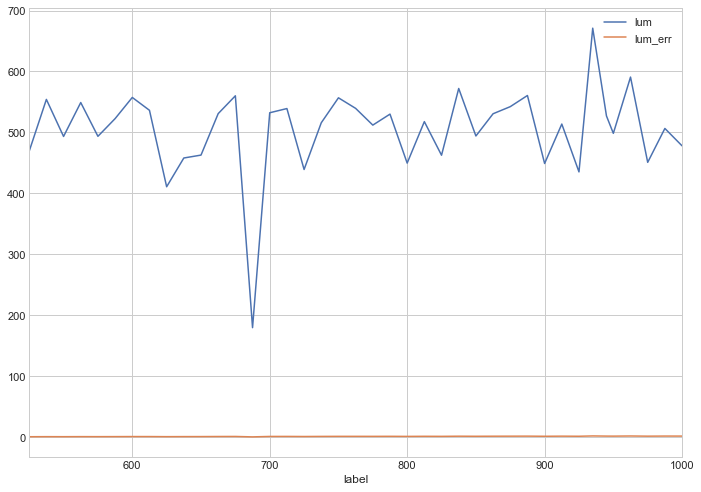

In [183]:
lum.sort_index().plot()

Join luminosity to data file

In [184]:
data = data.join(lum, how='inner')

In [185]:
lum.drop_duplicates().sort_index().head()

,lum,lum_err
label,,
525.0,469.339,1.10750
537.5,554.231,1.22073
550.0,493.501,1.17935
562.5,549.094,1.27306
575.0,493.710,1.23988


See how much events in each point I have

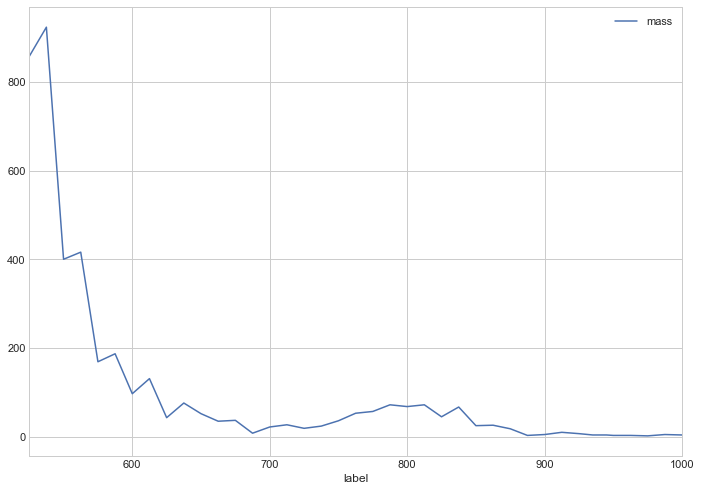

In [186]:
data.groupby('label').agg({'mass':np.size}).plot()

In [187]:
data.groupby('label').agg({'mass':np.size})

,mass
label,
525.0,857.0
537.5,923.0
550.0,400.0
562.5,416.0
575.0,169.0
587.5,187.0
600.0,97.0
612.5,131.0
625.0,43.0


Next stage: merge points with little data

In [189]:
#cnct = [] #model
#cnct = [([945., 950., 955.], 950)] #19year
#cnct = [([880., 890., 900., 910.], 900), ([920., 930., 936., 937.5], 935), ([942., 950., 971.], 960), 
#       ([981., 990, 1003.5],990)] #17 year
#cnct = [([900., 920., 936., 950., 960., 970., 980., 990], 960)] #12 year
cnct = [([875., 887.5], 880), ([900., 912.5, 925.], 910), ([935., 945., 950., 962.5, 975., 987.5, 1000.], 950)] #11year

In [190]:
data['label'] = data.index
for c in cnct:
    data.label.replace(c[0], c[1], inplace=True)
data.index = data.label
data.drop(['label'], axis=1, inplace=True)

OK, points have been merged

In [191]:
data.tail()

,beam_energy,mass,trigger,index,lum,lum_err
label,,,,,,
950.0,989.221008,527.203430,2,39,506.605,2.18062
950.0,1002.309998,496.517883,0,0,478.093,2.14453
950.0,1002.309998,481.866150,0,0,478.093,2.14453
950.0,1002.309998,494.471771,0,0,478.093,2.14453
950.0,1002.309998,498.673920,0,0,478.093,2.14453


Get true luminosity for merged events

In [192]:
data['lume'] = data.beam_energy*data.lum

Create new table with right values of energy and luminosity

In [193]:
new_lum = data[['beam_energy','lum', 'lume']].drop_duplicates().groupby('label').agg({'lume':[np.sum], 'lum':[np.sum], 
                        'beam_energy':[np.min, np.max]})

In [194]:
new_lum['Emean'] = np.round( new_lum[('lume','sum')]/new_lum[('lum','sum')], 2)

In [195]:
new_lum.columns = ['lume', 'lum', 'dEmin', 'dEmax', 'Emean']
new_lum.drop('lume', axis=1, inplace=True)
new_lum['dEmax'] = np.abs( np.round( new_lum.dEmax-new_lum.Emean, 2) )
new_lum['dEmin'] = np.abs( np.round( new_lum.Emean - new_lum.dEmin, 2) )

In [196]:
#data.loc[641.].beam_energy.std()

In [197]:
new_lum.tail(11)

,lum,dEmin,dEmax,Emean
label,,,,
775.0,512.087,0.00,0.00,771.60
787.5,530.109,0.00,0.00,785.93
800.0,449.786,0.00,0.00,796.90
812.5,517.806,0.00,0.00,811.46
825.0,462.699,0.00,0.00,821.52
837.5,572.151,0.00,0.00,834.72
850.0,494.236,0.00,0.00,846.43
862.5,530.712,0.00,0.00,861.56
880.0,1102.990,8.15,7.89,878.97


I have got new luminosity table.

Now I should joint it to existing table

In [198]:
data.drop(['lume', 'lum', 'beam_energy'], axis=1, inplace=True)
data = data.join(new_lum, how='inner')

That is good. Now I should do the analysis

In [199]:
data.tail()

,mass,trigger,index,lum_err,lum,dEmin,dEmax,Emean
label,,,,,,,,
950.0,527.203430,2,39,2.18062,3723.288,28.82,37.9,964.41
950.0,496.517883,0,0,2.14453,3723.288,28.82,37.9,964.41
950.0,481.866150,0,0,2.14453,3723.288,28.82,37.9,964.41
950.0,494.471771,0,0,2.14453,3723.288,28.82,37.9,964.41
950.0,498.673920,0,0,2.14453,3723.288,28.82,37.9,964.41


----------------
## Fit

In [200]:
data2 = data.groupby('label')

In [201]:
dic = {}
for i in data2.groups:
    print(i)
    dic[i] = np.array( data2.get_group(i)['mass'] )

525.0
537.5
550.0
562.5
575.0
587.5
600.0
612.5
625.0
637.5
650.0
662.5
675.0
687.5
700.0
712.5
725.0
737.5
750.0
762.5
775.0
787.5
800.0
812.5
825.0
837.5
850.0
862.5
880.0
910.0
950.0


In [202]:
import zfit

In [203]:
def chi2(data, pdf, bins):
    #write chi2 calculator
    return

In [204]:
bounds = (480, 550)
x = zfit.Space("x", bounds)

In [40]:
mu = zfit.Parameter("mu", 497.6, 480, 520)
sigma = zfit.Parameter("sigma", 7.5, 5, 11)
Nsig = zfit.Parameter("Nsig", 1e2, 1, 1e4)
Nbkg = zfit.Parameter("Nbkg", 1, 1e-4, 2e2)

In [205]:
sig_pdf = zfit.pdf.Gauss(obs=x, mu=mu, sigma=sigma)
bkg_pdf = zfit.pdf.Uniform(obs=x, low=bounds[0], high=bounds[1])
pdf = Nsig * sig_pdf + Nbkg * bkg_pdf

In [206]:
def fit(dic_data):
    data = zfit.Data.from_numpy(obs=x, array=dic_data)
    loss = zfit.loss.ExtendedUnbinnedNLL(model=pdf, data=data)
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(loss);
    return result

In [207]:
N_dic = dict()
itr = iter(dic)

In [208]:
i = next(itr)
print('Label:', i)

Label: 525.0


In [209]:
#print(i)
result = fit(dic[i])
#Fit quality
print(f"Converge: {result.converged}")
val = (result.params[Nsig]['value'] + result.params[Nbkg]['value'])
print(f"{dic[i].size} = {val:.1f}")

------------------------------------------------------------------
| FCN = -2044                   |     Ncalls=171 (171 total)     |
| EDM = 4.01E-06 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
Converge: True
857 = 832.0


Plotting

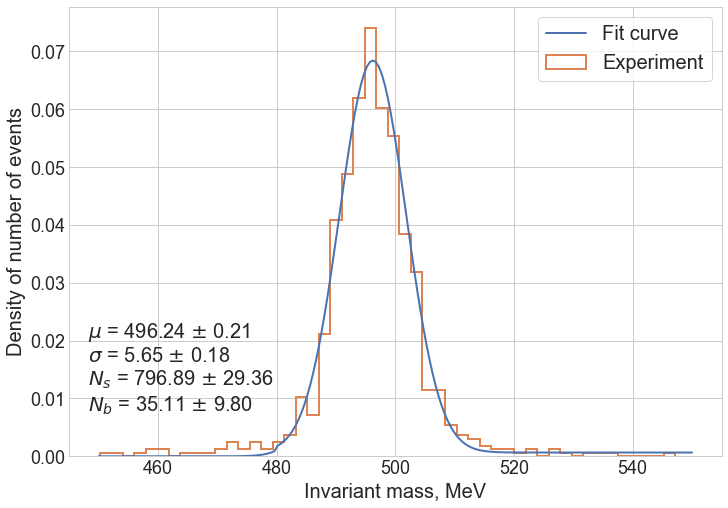

In [210]:
#get results
pars = result.params
errs = result.error()
mu_str = f"$\mu$ = {pars[mu]['value']:.2f} $\pm$ {errs[mu]['upper']:.2f}"
sigma_str = f"$\\sigma$ = {pars[sigma]['value']:.2f} $\pm$ {errs[sigma]['upper']:.2f}"
nsig_str = f"$N_s$ = {pars[Nsig]['value']:.2f} $\pm$ {errs[Nsig]['upper']:.2f}"
nbkg_str = f"$N_b$ = {pars[Nbkg]['value']:.2f} $\pm$ {errs[Nbkg]['upper']:.2f}"

#plot
x_dat = np.linspace(450, 550, 200)
y_dat = zfit.run(pdf.pdf(x_dat, norm_range=x))

plt.plot(x_dat, y_dat, label="Fit curve", lw=2)
plt.hist(dic[i], bins=50, histtype='step', density=True, label="Experiment", lw=2);

ax = plt.gca()
ax.tick_params(labelsize=18)
plt.ylabel("Density of number of events", fontsize=20);
plt.xlabel("Invariant mass, MeV", fontsize=20);
plt.legend(fontsize=20, loc='upper right', frameon=True);

#print parameters
param_str = f"{mu_str}\n{sigma_str}\n{nsig_str}\n{nbkg_str}"
ax.text(0.03, 0.1, param_str, fontsize=20, transform=ax.transAxes);

#write to table
N_dic[i] = [pars[Nsig]['value'], errs[Nsig]['upper']]
plt.savefig(f'../outputs/{year}/fits/e{i}.svg')

In [211]:
N_dic

{525.0: [796.8909387569952, 29.360033782367967]}

### Some notes:

11 { (600, 687.5, 725, 812.5) - only gauss,    (700, 737.5 : 20 bins; 880, 950 : 15 bins) }

12 { ( 910 :15 bins)}

17 { (725, 825, 880) - only gauss, (900 : 11 bins, 960 : 8 bins), 990 - govno }

In [154]:
#mt.matrix(correlation=True)
#mt.draw_profile('Nsig');

In [155]:
dataN = pd.DataFrame(N_dic)
dataN = dataN.T
dataN.columns = ['Nsig', 'dNsig']

In [156]:
dataN.tail()

,Nsig,dNsig
870.0,19.153628,5.131523
900.0,16.971123,6.345081
935.0,32.748296,7.430858
960.0,19.139203,6.836632
990.0,12.138809,5.359618


I have got table with events numbers

Now, I will get rid of m-field in the data table (because, I have used it)

In [157]:
data_info = data.drop_duplicates(['lum']).drop(['mass', 'trigger'], axis=1)

In [158]:
dataN = dataN.join(data_info, how='inner')
dataN

,Nsig,dNsig,index,lum_err,lum,dEmin,dEmax,Emean
641.0,305.562535,18.964480,1,3.34197,3097.960,0.00,0.00,641.02
650.0,93.445969,10.370172,2,1.80594,876.635,0.00,0.00,649.77
675.0,81.397425,9.798074,3,2.21501,1225.140,0.00,0.00,674.85
700.0,36.810455,6.879683,4,1.93961,876.658,0.00,0.00,700.56
725.0,59.878275,8.881077,5,2.26625,1114.220,0.00,0.00,724.94
750.0,92.368615,10.780846,6,2.33590,1107.580,0.00,0.00,749.55
800.0,162.933710,13.543247,7,2.63488,1241.540,0.00,0.00,800.86
825.0,187.494693,14.670781,8,2.86742,1381.860,0.00,0.00,825.05
840.0,77.510046,9.649992,9,1.98396,635.647,0.00,0.00,839.47
860.0,29.741629,5.966302,10,2.43867,922.378,0.00,0.00,857.23


OK, save it

In [159]:
dataN.to_csv(f'../outputs/{year}/out{year}.csv', float_format='%.2f')

Ok, now about triggers

In [160]:
triggers = data[['trigger']]
triggers['one'] = 1;

C:\Users\nikit\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [161]:
triggers = pd.pivot_table(triggers, values='one', columns=['trigger'], index='label', aggfunc=np.sum).fillna(0)

In [162]:
triggers.columns = ['TF', 'CF', 'TC']

In [163]:
triggers.head()

,TF,CF,TC
label,,,
641.0,83.0,4.0,258.0
650.0,13.0,0.0,87.0
675.0,25.0,4.0,64.0
700.0,11.0,1.0,31.0
725.0,13.0,2.0,49.0


In [164]:
def variance(k, n):
    return (k+1)*(k+2)/(n+2)/(n+3) - (k+1)**2/(n+2)**2

In [165]:
triggers['eTF'] = (triggers['TC'] + 1)/(triggers['CF'] + triggers['TC'] + 2)
triggers['eCF'] = (triggers['TC'] + 1)/(triggers['TF'] + triggers['TC'] + 2)
triggers['TrigEff'] = 1 - (1-triggers['eTF'])*(1-triggers['eCF'])

triggers['vTF'] = np.sqrt( variance(triggers['TC'], triggers['CF'] + triggers['TC']) )
triggers['vCF'] = np.sqrt( variance(triggers['TC'], triggers['TF'] + triggers['TC']) )
triggers['TrigErr'] = np.sqrt( np.square((1-triggers['eTF'])*triggers['vCF']) + 
                              np.square((1-triggers['eCF'])*triggers['vTF']) )

OK, trigers have been got

In [166]:
triggers.to_csv(f'../outputs/{year}/triggers{year}.csv', float_format='%.2f')

In [167]:
triggers

,TF,CF,TC,eTF,eCF,TrigEff,vTF,vCF,TrigErr
label,,,,,,,,,
641.0,83.0,4.0,258.0,0.981061,0.755102,0.995362,0.008374,0.023185,0.002097
650.0,13.0,0.0,87.0,0.988764,0.862745,0.998458,0.011110,0.033907,0.001572
675.0,25.0,4.0,64.0,0.928571,0.714286,0.979592,0.030564,0.047099,0.009358
700.0,11.0,1.0,31.0,0.941176,0.727273,0.983957,0.039772,0.066391,0.011529
725.0,13.0,2.0,49.0,0.943396,0.781250,0.987618,0.031447,0.051276,0.007466
750.0,24.0,3.0,75.0,0.950000,0.752475,0.987624,0.024216,0.042732,0.006364
800.0,36.0,3.0,133.0,0.971014,0.783626,0.993728,0.014230,0.031397,0.003211
825.0,49.0,2.0,146.0,0.980000,0.746193,0.994924,0.011393,0.030928,0.002957
840.0,27.0,0.0,60.0,0.983871,0.685393,0.994926,0.015871,0.048948,0.005055
